# Synthesize information about trained models

In [75]:
# imports
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import shap
import textwrap
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from IPython.display import display


<h3>Does dropping correlated features lead to a better model? (no)</h3>

In [31]:
# load
def load_agg(p: Path) -> pd.DataFrame:
    df = pd.read_csv(p)
    df["metric"] = df["metric"].astype(str)

    return df.set_index("metric")

# compare deltas of model accuracy across dfs with correlated cols deleted vs not deleted
def compare_agg_folders(no_corr_dir: str, corr_dir: str, out_p: str = "../results/deltas.csv"):
    no_files = {p.name: p for p in Path(no_corr_dir).glob("*_agg.csv")}
    co_files = {p.name: p for p in Path(corr_dir).glob("*_agg.csv")}
    
    common = sorted(set(no_files) & set(co_files))
    metric_cols = ["best_cv_acc", "test_acc", "test_precision", "test_recall", "test_f1", "test_roc_auc"]

    wide_rows = {}
    for fname in common:
        df_no = load_agg(no_files[fname])
        df_co = load_agg(co_files[fname])

        # delta_mean = no_corr - corr
        delta_mean = df_no["mean"] - df_co["mean"]

        model = fname.replace("_agg.csv", "")
        wide_rows[model] = delta_mean.reindex(metric_cols)

    deltas = pd.DataFrame.from_dict(wide_rows, orient="index")
    deltas.index.name = "model"
    deltas.to_csv(out_p)

    return deltas

# deltas = compare_agg_folders(no_corr_dir="../results/no_ftrs_dropped", corr_dir="../results/ftrs_dropped")
# print(deltas)


<h3>Find top two models for primary and secondary evaluation metrics</h3>

In [32]:
# find best 2 models for each eval metric

root = Path("../results/final") 

rows = []

for p in root.rglob("*_agg.csv"):
    df = pd.read_csv(p)

    model = p.stem.replace("_agg", "")

    for _, r in df.iterrows():
        rows.append({"model": model, "metric": r["metric"], "mean": r["mean"], "std": r["std"]})

all_metrics = pd.DataFrame(rows)

per_metric = (all_metrics
    .sort_values(["metric", "mean", "std"], ascending=[True, False, True])
    .groupby("metric", as_index=False).head(10).reset_index(drop=True))

per_metric.to_csv('../results/final/best_per_metric.csv', index=False)
print(per_metric)

             model          metric      mean       std
0              rfc     best_cv_acc  0.579603  0.010483
1              xgb     best_cv_acc  0.576204  0.015965
2              svc     best_cv_acc  0.565788  0.007257
3        logreg_l2     best_cv_acc  0.562295  0.015133
4   logreg_elastic     best_cv_acc  0.560556  0.019175
5              knn     best_cv_acc  0.553193  0.012936
6              svc        test_acc  0.569231  0.055403
7              rfc        test_acc  0.557692  0.080448
8        logreg_l2        test_acc  0.550000  0.075222
9   logreg_elastic        test_acc  0.546154  0.061718
10             knn        test_acc  0.507692  0.064645
11             xgb        test_acc  0.484615  0.053363
12             svc         test_f1  0.524075  0.123695
13             rfc         test_f1  0.501671  0.143305
14       logreg_l2         test_f1  0.485011  0.145865
15  logreg_elastic         test_f1  0.479988  0.131420
16             xgb         test_f1  0.437024  0.164438
17        

# Global Feature Importances

In [33]:
# save states
pipe_path = Path("../results/final/grid_pipe")
random_states= [0,1,2,3,5]

model_name = "rfc"
models = ['logreg_l2', 'logreg_elastic', 'rfc', 'svc', 'knn', 'xgb']

In [140]:
# group utilities
def strip_transformer(name: str) -> str:
    s = name.split("__", 1)[1] if "__" in name else name

    return s.split("=", 1)[0]

def to_family(name: str) -> str:
    s = strip_transformer(name)

    return s.split("_", 1)[0]

def to_stat_type(name: str) -> str:
    s = strip_transformer(name)
    
    return s.rsplit("_", 1)[-1] if "_" in s else s

def pretty(s):
    s = str(s)
    if "__" in s: s = s.split("__", 1)[1]

    if s.endswith("_FULL"):
        s = s[:-5]
        
    return s

<h3>Confusion Matrix</h3>

In [51]:
# confusion matrix

def cm_percent_mean_std(p, model_n, seeds, label_names=("0","1")):
    cms_pct = []; accs = []; balances = [] # majority class bal in holdout

    for seed in seeds:
        with open(p/f"{model_n}_seed{seed}_best_pipe.pkl", "rb") as f: pipe = pickle.load(f)
        with open(p/f"{model_n}_seed{seed}_X_test.pkl", "rb") as f: X_test = pickle.load(f)
        with open(p/f"{model_n}_seed{seed}_y_test.pkl", "rb") as f: y_test = pickle.load(f)

        y_pred = pipe.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        cm_pct = cm / cm.sum() * 100.0
        cms_pct.append(cm_pct)

        accs.append((y_pred == np.asarray(y_test)).mean() * 100.0)

        p_pos = float(np.mean(y_test))
        balances.append(max(p_pos, 1 - p_pos) * 100.0)

    cms_pct = np.stack(cms_pct, axis=0)
    mean = cms_pct.mean(axis=0)
    std  = cms_pct.std(axis=0)

    acc_mean, acc_std = np.mean(accs), np.std(accs)
    bal_mean, bal_std = np.mean(balances), np.std(balances)

    a, b = label_names
    print(f"{model_n}, {len(seeds)} seeds: {acc_mean:.2f} +- {acc_std:.2f}% accuracy "
          f"(holdout majority-class balance {bal_mean:.2f} +- {bal_std:.2f}%).\n")

    print(f"{'true \\ pred':<12} {a:<18} {b:<18}")
    print(f"{a:<12} {mean[0,0]:5.2f} +- {std[0,0]:3.2f}%  {mean[0,1]:5.2f} +- {std[0,1]:3.2f}%")
    print(f"{b:<12} {mean[1,0]:5.2f} +- {std[1,0]:3.2f}%  {mean[1,1]:5.2f} +- {std[1,1]:3.2f}%")


# call
cm_percent_mean_std(pipe_path, model_name, random_states, label_names=("loss","win"))


rfc, 5 seeds: 55.77 +- 8.04% accuracy (holdout majority-class balance 51.92 +- 0.00%).

true \\ pred loss               win               
loss         32.31 +- 5.51%  19.62 +- 5.51%
win          24.62 +- 9.16%  23.46 +- 9.16%


<h3>Permutation Importance</h3>

In [56]:
out = Path("../results/final/perm_importance")
out.mkdir(parents=True, exist_ok=True)
scoring = "accuracy"
n_repeats = 5

all_rows = []

for r in random_states:
    with open(pipe_path/f"{model_name}_seed{r}_best_pipe.pkl", "rb") as f: pipe = pickle.load(f)
    with open(pipe_path/f"{model_name}_seed{r}_X_test.pkl", "rb") as f: X_test = pickle.load(f)
    with open(pipe_path/f"{model_name}_seed{r}_y_test.pkl", "rb") as f: y_test = pickle.load(f)

    perm_res = permutation_importance(
        pipe,
        X_test,
        y_test,
        scoring=scoring,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=5)

    for feat, mean_imp, std_imp in zip(X_test.columns, perm_res.importances_mean, perm_res.importances_std):
        all_rows.append({
            "seed": r,
            "feature": feat,
            "importance": float(mean_imp),
            "importance_std": float(std_imp)})

imp_df = pd.DataFrame(all_rows)

# aggregate across seeds
imp_summary = (imp_df.groupby("feature")["importance"].agg(mean="mean", std="std")
               .sort_values("mean", ascending=False).reset_index())

tag = f"{model_name}_scoring-{scoring}_repeats-{n_repeats}_seeds-{len(random_states)}"
imp_df.to_csv(out/f"{tag}_per_seed.csv", index=False)
imp_summary.to_csv(out/f"{tag}_summary.csv", index=False)

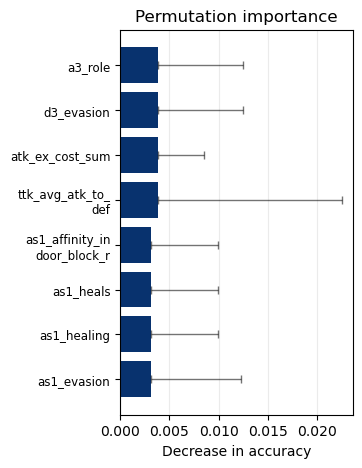

In [112]:
k = 8
top = imp_summary.head(k).iloc[::-1].copy()

labels = [textwrap.fill(s, width=15) for s in top["feature"].astype(str).tolist()]

cmap = plt.get_cmap("Blues")
colors = [cmap(x) for x in np.linspace(0.1, 1, k)]

right_err = top["std"].to_numpy()
xerr = np.vstack([np.zeros_like(right_err), right_err])

plt.figure(figsize=(3, 5))
plt.barh(
    labels,
    top["mean"],
    xerr=xerr,
    color=cmap(0.99),
    edgecolor="none",
    error_kw=dict(elinewidth=1.0, capsize=3, capthick=1.0, alpha=0.55))

plt.yticks(fontsize=8.5)
plt.title("Permutation importance")
plt.xlabel("Decrease in accuracy")
plt.grid(axis="x", alpha=0.25)

plt.savefig('../figures/eval/perm_imp.png', dpi=300, bbox_inches='tight')
plt.show()

<h3>Linear model feature weights (outdated)</h3>

In [55]:
# model_l = 'logreg_elastic'

# # extract coef from fitted pipe
# def get_coef_importance_df(pipe, class_index=0):
#     clf = pipe.named_steps.get("clf", None) or pipe[-1]
#     pre = pipe.named_steps.get("prep", None) or pipe[0]

#     feat_names = pre.get_feature_names_out()
#     coefs = clf.coef_
    
#     # binary or multiclass
#     if coefs.ndim == 2 and coefs.shape[0] > 1:
#         coef_vec = coefs[class_index]
#     else:
#         coef_vec = coefs.ravel()

#     return (pd.DataFrame({
#         "feature_transformed": feat_names,
#         "coef": coef_vec,
#         "abs_coef": np.abs(coef_vec),
#     }).sort_values("abs_coef", ascending=False))

# all_rows = []
# for r in random_states:
#     with open(pipe_path/f"{model_l}_seed{r}_best_pipe.pkl", "rb") as f: pipe = pickle.load(f)

#     w = get_coef_importance_df(pipe)
#     w["seed"] = r
#     w["family"] = w["feature_transformed"].map(to_family)
#     w["stat_type"] = w["feature_transformed"].map(to_stat_type)
#     all_rows.append(w)

# w_df = pd.concat(all_rows, ignore_index=True)

# # per transformed feature
# w_summary = (w_df.groupby("feature_transformed")["abs_coef"]
#              .agg(mean="mean", std="std").sort_values("mean", ascending=False).reset_index())

# display(w_summary.head(5))

# # per family
# w_family = (w_df.groupby(["seed","family"])["abs_coef"].sum().reset_index()
#             .groupby("family")["abs_coef"].agg(mean="mean", std="std")
#             .sort_values("mean", ascending=False).reset_index())

# display(w_family.head(5))

# # per stat type
# w_type = (w_df.groupby(["seed","stat_type"])["abs_coef"].sum().reset_index()
#           .groupby("stat_type")["abs_coef"].agg(mean="mean", std="std")
#           .sort_values("mean", ascending=False).reset_index())

# display(w_type.head(5))

<h3>Impurity-based feature importance (NEW) </h3>

In [136]:
def get_ftr_names(pipe):

    return pipe[:-1].get_feature_names_out()

def mdi_imp(p: Path, rs, model_n):
    rows = []

    for r in rs:
        with open(p/f"{model_n}_seed{r}_best_pipe.pkl", "rb") as f:
            pipe = pickle.load(f)

        rf = pipe.named_steps["clf"]
        feat_names = get_ftr_names(pipe)
        imp = rf.feature_importances_

        df = pd.DataFrame({"feature": feat_names, "importance": imp})
        df["seed"] = r
        rows.append(df)

    all_df = pd.concat(rows, ignore_index=True)

    out = (all_df.groupby("feature")["importance"]
                 .agg(["mean", "std"]).sort_values("mean", ascending=False)
                 .reset_index())
    return out

mdi_df = mdi_imp(pipe_path, rs=random_states, model_n=model_name)
mdi_df

,feature,mean,std
0,num__diff_healing_std_FULL,0.011797,0.002889
1,num__diff_evasion_mean_FULL,0.011465,0.004540
2,num__diff_accuracy_std_FULL,0.010197,0.002571
3,num__diff_ex_cost_std_FULL,0.010007,0.002736
4,num__ttk_avg_atk_to_def,0.009502,0.002993
...,...,...,...
862,cat__a4_mika,0.000000,0.000000
863,num__a1_block_rate_bonus,0.000000,0.000000
864,num__a1_atk_spd,0.000000,0.000000
865,cat__ds2_unit_type_support,0.000000,0.000000


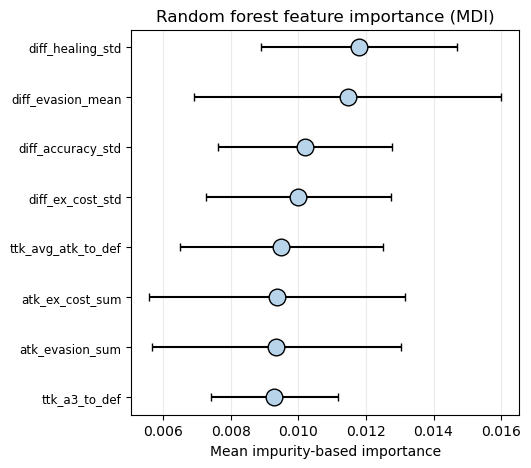

In [175]:
top = mdi_df.head(8).iloc[::-1].copy()
top["label"] = top["feature"].map(pretty)
y = np.arange(len(top))

plt.figure(figsize=(5, 5))
plt.errorbar(top["mean"], y, xerr=top["std"], fmt="o", capsize=3, ecolor='black', \
             markersize=12, markeredgecolor='black', markerfacecolor=cmap(0.3))
plt.yticks(y, top["label"], fontsize=8.5)
plt.xlabel("Mean impurity-based importance")
plt.title("Random forest feature importance (MDI)")
plt.grid(axis="x", alpha=0.25)

plt.savefig('../figures/eval/mdi_imp.png', dpi=300, bbox_inches='tight')
plt.show()

<h3>Global SHAP</h3>

In [118]:
# do global shap
def shap_global_linear(pipe, X, max_background=200):
    clf = pipe.named_steps["clf"]
    pre = pipe.named_steps["prep"]

    Xtr = pre.transform(X)
    feat_names = pre.get_feature_names_out()

    bg = Xtr[:max_background]

    explainer = shap.LinearExplainer(clf, bg)
    sv = explainer.shap_values(Xtr)

    mean_abs = np.mean(np.abs(sv), axis=0)

    df = (pd.DataFrame({"feature_transformed": feat_names, "mean_abs_shap": mean_abs})
        .sort_values("mean_abs_shap", ascending=False))

    return df

rows = []
for r in random_states:
    with open(pipe_path/f"{model_name}_seed{r}_best_pipe.pkl", "rb") as f: pipe = pickle.load(f)
    with open(pipe_path/f"{model_name}_seed{r}_X_test.pkl", "rb") as f: X_test = pickle.load(f)

    s = shap_global_tree(pipe, X_test, class_idx=1)
    s["seed"] = r
    s["family"] = s["feature_transformed"].map(to_family)
    s["stat_type"] = s["feature_transformed"].map(to_stat_type)
    rows.append(s)

shap_df = pd.concat(rows, ignore_index=True)

# per transformed feature
shap_global_summary = (shap_df.groupby("feature_transformed")["mean_abs_shap"]
                       .agg(mean="mean", std="std")
                       .sort_values("mean", ascending=False).reset_index())

display(shap_global_summary.head(5))

# per family
shap_family = (shap_df.groupby(["seed","family"])["mean_abs_shap"].sum().reset_index()
               .groupby("family")["mean_abs_shap"].agg(mean="mean", std="std")
               .sort_values("mean", ascending=False).reset_index())

display(shap_family.head(5))

# per stat type
shap_type = (shap_df.groupby(["seed","stat_type"])["mean_abs_shap"].sum().reset_index()
             .groupby("stat_type")["mean_abs_shap"].agg(mean="mean", std="std")
             .sort_values("mean", ascending=False).reset_index())

display(shap_type.head(5))


InvalidModelError: An unknown model type was passed: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

In [113]:
# shap plot for one seed = 0, topk features

rs = 0
top_k = 8

with open(pipe_path/f"{model_name}_seed{rs}_best_pipe.pkl", "rb") as f: pipe = pickle.load(f)
with open(pipe_path/f"{model_name}_seed{rs}_X_test.pkl", "rb") as f: X_test = pickle.load(f)

clf = pipe.named_steps["clf"]
pre = pipe.named_steps["prep"]

Xtr = pre.transform(X_test)
feature_names = pre.get_feature_names_out()

bg = Xtr[:200]
Xplot = Xtr[:1000]

explainer = shap.LinearExplainer(clf, bg)
sv = explainer.shap_values(Xplot)

mean_abs = np.mean(np.abs(sv), axis=0)
top_idx = np.argsort(mean_abs)[-top_k:]

sv_top = sv[:, top_idx]
Xplot_top = Xplot[:, top_idx]
feature_names_top = feature_names[top_idx]

shap.summary_plot(sv_top, Xplot_top, feature_names=feature_names_top, max_display=top_k)

InvalidModelError: An unknown model type was passed: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

# Local Feature Importances

<h3>Local SHAP</h3>

In [45]:
shap.initjs()

In [47]:
indices = [2]

# baseline
base = explainer.expected_value
print(base)

# loop and see local point explanations
for index in indices:
    sv_row = sv[index,:]
    x_row  = Xplot[index,:]
    
    print("og row id:", X_test.index[index])
    display(shap.force_plot(base, sv_row, features=x_row, feature_names=feature_names))


-0.07492212782539129
og row id: 320


In [43]:
# show one parameter set
def pick_one_paramset_per_model(cv_dir: Path, model_n: str, seeds, score_col="mean_test_score"):
    dfs = []
    for s in seeds:
        df = pd.read_csv(cv_dir / f"{model_n}_seed{s}_cv_results.csv")
        df["seed"] = s
        dfs.append(df)

    all_cv = pd.concat(dfs, ignore_index=True)

    agg = (all_cv.groupby("params")[score_col]
           .agg(mean="mean", std="std", n="count")
           .sort_values("mean", ascending=False).reset_index())

    best = agg.iloc[0]
    
    return best["params"], float(best["mean"]), float(best["std"]), agg

for m in models:
    best_params, best_mean, best_std, agg = pick_one_paramset_per_model(pipe_path, m, random_states)
    print(m)
    print("report max cv across seeds:", best_params)
    print(f"mean cv score across seeds: {best_mean:.3f} +- {best_std:.3f}")
    print('\n')


logreg_l2
report max cv across seeds: {'clf__C': 0.001, 'clf__class_weight': None}
mean cv score across seeds: 0.561 +- 0.015


logreg_elastic
report max cv across seeds: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__l1_ratio': 0.95}
mean cv score across seeds: 0.554 +- 0.019


rfc
report max cv across seeds: {'clf__class_weight': None, 'clf__max_depth': 3, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__n_estimators': 500}
mean cv score across seeds: 0.565 +- 0.016


svc
report max cv across seeds: {'clf__C': 1, 'clf__class_weight': None, 'clf__gamma': 'scale'}
mean cv score across seeds: 0.561 +- 0.012


knn
report max cv across seeds: {'clf__n_neighbors': 2, 'clf__p': 1, 'clf__weights': 'uniform'}
mean cv score across seeds: 0.548 +- 0.012


xgb
report max cv across seeds: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 1, 'clf__reg_lambda': 1.0, 'clf__subsample': 0.6}
mean cv score across seeds: 0.546 +- 0.026




<h3>Misc</h3>

In [ ]:
# how many boosted rounds did xgb go thru

with open(pipe_path/f"xgb_seed{0}_best_pipe.pkl", "rb") as f: pipe = pickle.load(f)

clf = pipe.named_steps["clf"]
booster = clf.booster_

print("num_boosted_rounds:", booster.num_boosted_rounds())